In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage import io, transform
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import h5py
import numpy as np
from torch.utils.data import Dataset
import pandas as pd
from os.path import join as pjoin
import sys

# Load correlation coefficient matrix

In [3]:
mat_fname = '/scratch/users/wx2203/cmdata/cc_no_ds_ww_11_94regions_cm125.mat'
f = h5py.File(mat_fname,'r')
### loading correlation matrices (window size=11, 94 regions)
cc_no_ds = np.empty((0,8836), float)
for i in range(3):
    a = f['cc_no_ds'][i,0]
    temp = np.array(f[a])
    temp = temp[5:-14,:] # trim first5 and last 15 frames
    cc_no_ds = np.append(cc_no_ds,temp,axis=0) #(11960*3, 8836)
print(cc_no_ds.shape) # time by correlation coefficient

(35880, 8836)


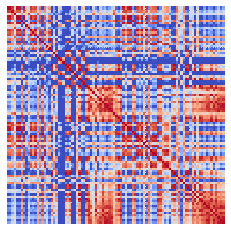

In [4]:
sns.heatmap(cc_no_ds.reshape((35880,94,94))[2811,:,:],
            square=True,cmap='coolwarm',vmin=0,vmax=1,cbar=False,
           xticklabels=False, yticklabels=False)

# VAE Encoding

In [5]:
class VAE(nn.Module):
    def __init__(self,hparam,fc_units):
        super(VAE, self).__init__()
        self.hparam = hparam
        self.fc_units = fc_units
        

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(8836, self.fc_units)
        self.fc_bn1 = nn.BatchNorm1d(self.fc_units)
        self.fc21 = nn.Linear(self.fc_units, self.hparam['n_latents'])
        self.fc22 = nn.Linear(self.fc_units, self.hparam['n_latents'])

        # Sampling vector
        self.fc3 = nn.Linear(self.hparam['n_latents'], self.fc_units)
#         self.fc_bn3 = nn.BatchNorm1d(self.hparam['n_latents'])
        self.fc_bn3 = nn.BatchNorm1d(self.fc_units)
        self.fc4 = nn.Linear(self.fc_units,  8836)
        self.fc_bn4 = nn.BatchNorm1d( 8836)

        self.relu = nn.ReLU()

    def encode(self, x):

        # calculate latent vectors
        fc1 = self.relu(self.fc_bn1(self.fc1(x)))
        # mu and std
        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        # sample from latent vectors
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))#.view(-1, 8836)

        return fc4

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [7]:
class MyDataset(Dataset):

    # Initialize  data
    def __init__(self, train_data):
        self.train_tensor = torch.from_numpy(train_data).float()
        self.len = self.train_tensor.shape[0]

    def __getitem__(self, index):
        return self.train_tensor[index]

    def __len__(self):
        return self.len

In [8]:
hparam = {'n_latents':20}
fc_units = 400
model = VAE(hparam=hparam,fc_units=fc_units)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
batch_size = 64
epochs = 60
no_cuda = True
seed = 1
log_interval = 50
cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': False} if cuda else {}
device

device(type='cpu')

In [10]:
X_train, X_test = train_test_split(
    cc_no_ds, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(
    dataset = MyDataset(X_train),
    batch_size = batch_size,
    drop_last=True,
     **kwargs)

val_loader = torch.utils.data.DataLoader(
    dataset = MyDataset(X_test),
    batch_size = batch_size,
    drop_last=True,
     **kwargs)

In [12]:
results_root = '/home/wx2203/STCS/trash/trash3/'
loss_mse = customLoss()
val_losses = []
train_losses = []
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    train_losses.append(train_loss / len(train_loader.dataset))
    # Print model's state_dict
    print("Saving model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, results_root+'epoch_'+str(epoch)+'.pth')
    print("Saved")



In [13]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            #data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_mse(recon_batch, data, mu, logvar).item()
           

    test_loss /= len(val_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/32292 (0%)]	Loss: 5068.070801
Train Epoch: 1 [3200/32292 (10%)]	Loss: 2261.760986
Train Epoch: 1 [6400/32292 (20%)]	Loss: 1968.874512
Train Epoch: 1 [9600/32292 (30%)]	Loss: 1780.874512
Train Epoch: 1 [12800/32292 (40%)]	Loss: 1377.426392
Train Epoch: 1 [16000/32292 (50%)]	Loss: 1374.991821
Train Epoch: 1 [19200/32292 (60%)]	Loss: 1290.845581
Train Epoch: 1 [22400/32292 (69%)]	Loss: 1310.346313
Train Epoch: 1 [25600/32292 (79%)]	Loss: 1261.587280
Train Epoch: 1 [28800/32292 (89%)]	Loss: 1157.354004
Train Epoch: 1 [32000/32292 (99%)]	Loss: 1214.039917
====> Epoch: 1 Average loss: 1596.7018
Saving model's state_dict:
fc1.weight 	 torch.Size([400, 8836])
fc1.bias 	 torch.Size([400])
fc_bn1.weight 	 torch.Size([400])
fc_bn1.bias 	 torch.Size([400])
fc_bn1.running_mean 	 torch.Size([400])
fc_bn1.running_var 	 torch.Size([400])
fc_bn1.num_batches_tracked 	 torch.Size([])
fc21.weight 	 torch.Size([20, 400])
fc21.bias 	 torch.Size([20])
fc22.weight 	 torch.Size([20, 400])
fc2

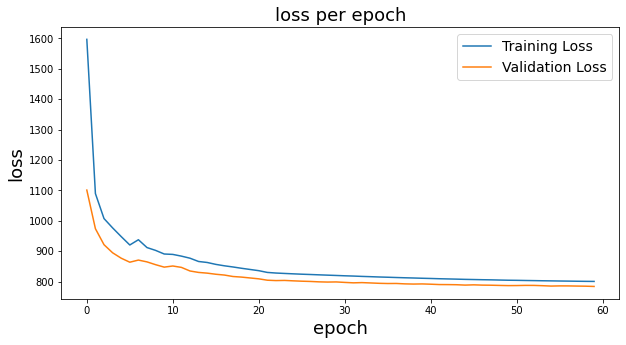

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.title("loss per epoch",fontsize=18)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.show()

In [22]:
with torch.no_grad():
    mu, logvar = model.encode(torch.from_numpy(X_test).float())
    z = model.reparameterize(mu, logvar)
    recon_data = model.decode(z)
recon_data = recon_data.numpy()

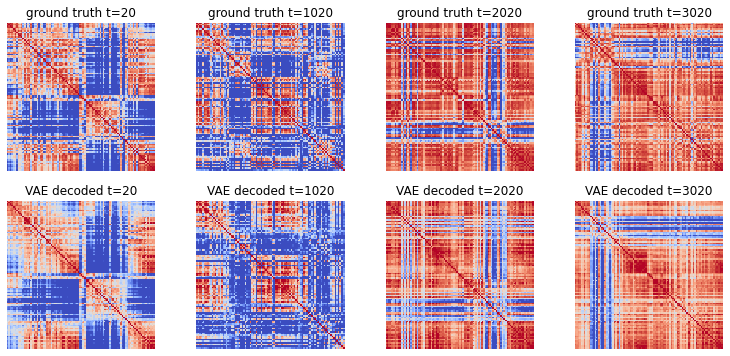

In [30]:
timeframes = range(20,4020,1000)
plt.figure(figsize=(13,6))
for i_tf,timeframe in enumerate(timeframes):
    plt.subplot(2,4,i_tf+1)
    sns.heatmap(X_test.reshape((X_test.shape[0],94,94))[timeframe,:,:],
                square=True,cmap='coolwarm',vmin=0,vmax=1,cbar=False,
               xticklabels=False, yticklabels=False)
    plt.title('ground truth t='+str(timeframe))
    plt.subplot(2,4,i_tf+5)
    sns.heatmap(recon_data.reshape((X_test.shape[0],94,94))[timeframe,:,:],
                square=True,cmap='coolwarm',vmin=0,vmax=1,cbar=False,
               xticklabels=False, yticklabels=False)
    plt.title('VAE decoded t='+str(timeframe))

In [33]:
with torch.no_grad():
    mu, logvar = model.encode(torch.from_numpy(cc_no_ds).float())
    z = model.reparameterize(mu, logvar)
    recon_data = model.decode(z).numpy()
    z = z.numpy()

In [34]:
with h5py.File('z_cm125_1.hdf5', 'w') as f:
    f.create_dataset("z", data=z)
    f.create_dataset("recon_data", data=recon_data)